# Try an InfoGAN on MNIST

In [1]:
%matplotlib inline
#Import a ton of stuff
import os
import struct
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from Progbar import Progbar

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from layers import Conv2d, ConvTranspose2d, Linear
from InfoGAN import InfoGAN

## Load the MNIST Data

In [2]:
# Load the MNIST CSV data from https://pjreddie.com/projects/mnist-in-csv/
# data_train = np.genfromtxt('./MNIST_Data/mnist_train.csv', delimiter = ',').astype(np.uint8)
# data_test = np.genfromtxt('./MNIST_Data/mnist_test.csv', delimiter = ',').astype(np.uint8)

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

data_train = read_idx('./MNIST_Data/train-images-idx3-ubyte')
data_test = read_idx('./MNIST_Data/t10k-images-idx3-ubyte')

targets_train = read_idx('./MNIST_Data/train-labels-idx1-ubyte')
targets_test = read_idx('./MNIST_Data/t10k-labels-idx1-ubyte')
print(data_train.shape, data_test.shape, targets_train.shape, targets_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [3]:
# Now reformat it into the format we want
# NOTE: PyTorch is weird so if we wanted to use cross entropy we need to keep them as logits, but we won't so...
x_train = np.expand_dims(data_train, 1)
y_train = np.zeros((targets_train.shape[0], 10), dtype = np.uint8)
y_train[np.arange(targets_train.shape[0]), targets_train] = 1

x_test = np.expand_dims(data_test, 1)
y_test = np.zeros((data_test.shape[0], 10), dtype = np.uint8)
y_test[np.arange(targets_test.shape[0]), targets_test] = 1

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Looks like we can convert our x to unint8
# We'll convert back to float and rescale to between 0 and 1 on the GPU batchwise to save CPU RAM
print(np.unique(x_train))
x_train = x_train.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

(60000, 1, 28, 28) (60000, 10)
(10000, 1, 28, 28) (10000, 10)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 2

[0 0 0 0 0 0 0 1 0 0]


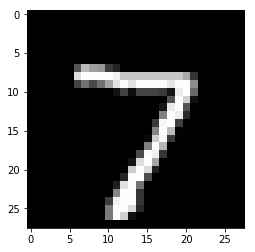

In [4]:
# Show an example from the test set
print(y_test[0])
plt.figure(0)
plt.imshow(x_test[0, 0], cmap = 'gray')

## PyTorch-ify our data and set the number of random samples we want to supervise with

In [5]:
supervision = 100 # Number of samples to supervise with

# Prep the data by turning them into tensors and putting them into a PyTorch dataloader
shuffle_train = np.random.permutation(y_train.shape[0])
x_train_th = torch.from_numpy(x_train[shuffle_train])
y_train_th = torch.from_numpy(y_train[shuffle_train]).float()

x_test_th = torch.from_numpy(x_test)
y_test_th = torch.from_numpy(y_test)

# OK, we're going to be hacking this out. We'll multiply by the sum of the labels
# So to make this semisupervised, we set the labels we don't want to 0
y_train_th[int(supervision):] = 0

train_tensors = TensorDataset(x_train_th, y_train_th)
test_tensors = TensorDataset(x_test_th, y_test_th)
train_loader = DataLoader(train_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)
test_loader = DataLoader(test_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)

## Create our network
* c1_len is the length of the multinomial coding vector
* c2_len is the length of the Gaussian coding vector
* c3_len is the length of the Bernoulli coding vector. Note the original paper doesn't using any bernoulli codes
* z_len is the length of the noise vector
* embedding_len is  the length of the embedding output from the discriminator to compute the latent codes

In [6]:
# Now let's start building the GAN
# But first, we're going to redefine Conv2D and Linear with our own initialisations
# We're going to use Glorot (aka Xavier) uniform init for all weights
# And we will use zero init for all biases

c1_len = 10 # Multinomial
c2_len = 2 # Gaussian
c3_len = 0 # Bernoulli
z_len = 64 # Noise vector length
embedding_len = 128

class Conv2d(nn.Conv2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class ConvTranspose2d(nn.ConvTranspose2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Linear(nn.Linear):
    def reset_parameters(self):
        stdv = np.sqrt(6 / (self.in_features + self.out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = Linear(z_len + c1_len + c2_len + c3_len, 1024)
        self.fc2 = Linear(1024, 7 * 7 * 128)

        self.convt1 = ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.convt2 = ConvTranspose2d(64, 1, kernel_size = 4, stride = 2, padding = 1)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(7 * 7 * 128)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x))).view(-1, 128, 7, 7)

        x = F.relu(self.bn3(self.convt1(x)))
        x = self.convt2(x)

        return F.sigmoid(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = Conv2d(1, 64, kernel_size = 4, stride = 2, padding = 1) # 28 x 28 -> 14 x 14
        self.conv2 = Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1) # 14 x 14 -> 7 x 7

        self.fc1 = Linear(128 * 7 ** 2, 1024)
        self.fc2 = Linear(1024, 1)
        self.fc1_q = Linear(1024, embedding_len)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn_q1 = nn.BatchNorm1d(embedding_len)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.bn1(self.conv2(x))).view(-1, 7 ** 2 * 128)

        x = F.leaky_relu(self.bn2(self.fc1(x)))
        return self.fc2(x), F.leaky_relu(self.bn_q1(self.fc1_q(x)))

In [7]:
# OK, now we create the actual models
gen = Generator().cuda()
dis = Discriminator().cuda()

In [8]:
# Link it all together into the InfoGAN. Also add the output layers for the latent codes
gan = InfoGAN(gen, dis, embedding_len, z_len, c1_len, c2_len, c3_len)

Start training
Epoch  1
60000/60000 [==============================] - 25s - loss_dis: 0.5873 - loss_gen: 0.5077 - loss_q: 0.3038    

Epoch  2
60000/60000 [==============================] - 20s - loss_dis: 0.3603 - loss_gen: 0.4511 - loss_q: 0.1116    

Epoch  3
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.4070 - loss_gen: 0.4087 - loss_q: 0.0762
Epoch  4
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.4182 - loss_gen: 0.3779 - loss_q: 0.0573
Epoch  5
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.4136 - loss_gen: 0.3767 - loss_q: 0.0430
Epoch  6
60000/60000 [==============================] - 19s - loss_dis: 0.4209 - loss_gen: 0.3762 - loss_q: 0.0369    

Epoch  7
60000/60000 [==============================] - 20s - loss_dis: 0.4235 - loss_gen: 0.3714 - loss_q: 0.0309    

Epoch  8
60000/60000 [==============================] - 20s - loss_dis: 0.4196 - loss_gen: 0.3745 - loss_q: 0.0274    

Epoch  9
60000/60000 [======

60000/60000 [==============================] - 19s - loss_dis: 0.0919 - loss_gen: 0.8684 - loss_q: 0.0172    

Epoch  69
60000/60000 [==============================] - 20s - loss_dis: 0.0926 - loss_gen: 0.8681 - loss_q: 0.0183    

Epoch  70
60000/60000 [==============================] - 19s - loss_dis: 0.0912 - loss_gen: 0.8716 - loss_q: 0.0191    

Epoch  71
60000/60000 [==============================] - 19s - loss_dis: 0.0887 - loss_gen: 0.8738 - loss_q: 0.0193    

Epoch  72
60000/60000 [==============================] - 19s - loss_dis: 0.0886 - loss_gen: 0.8729 - loss_q: 0.0180    

Epoch  73
60000/60000 [==============================] - 19s - loss_dis: 0.0879 - loss_gen: 0.8760 - loss_q: 0.0167    

Epoch  74
60000/60000 [==============================] - 20s - loss_dis: 0.0865 - loss_gen: 0.8753 - loss_q: 0.0177    

Epoch  75
60000/60000 [==============================] - 19s - loss_dis: 0.0882 - loss_gen: 0.8772 - loss_q: 0.0197    

Epoch  76
59904/60000 [===================

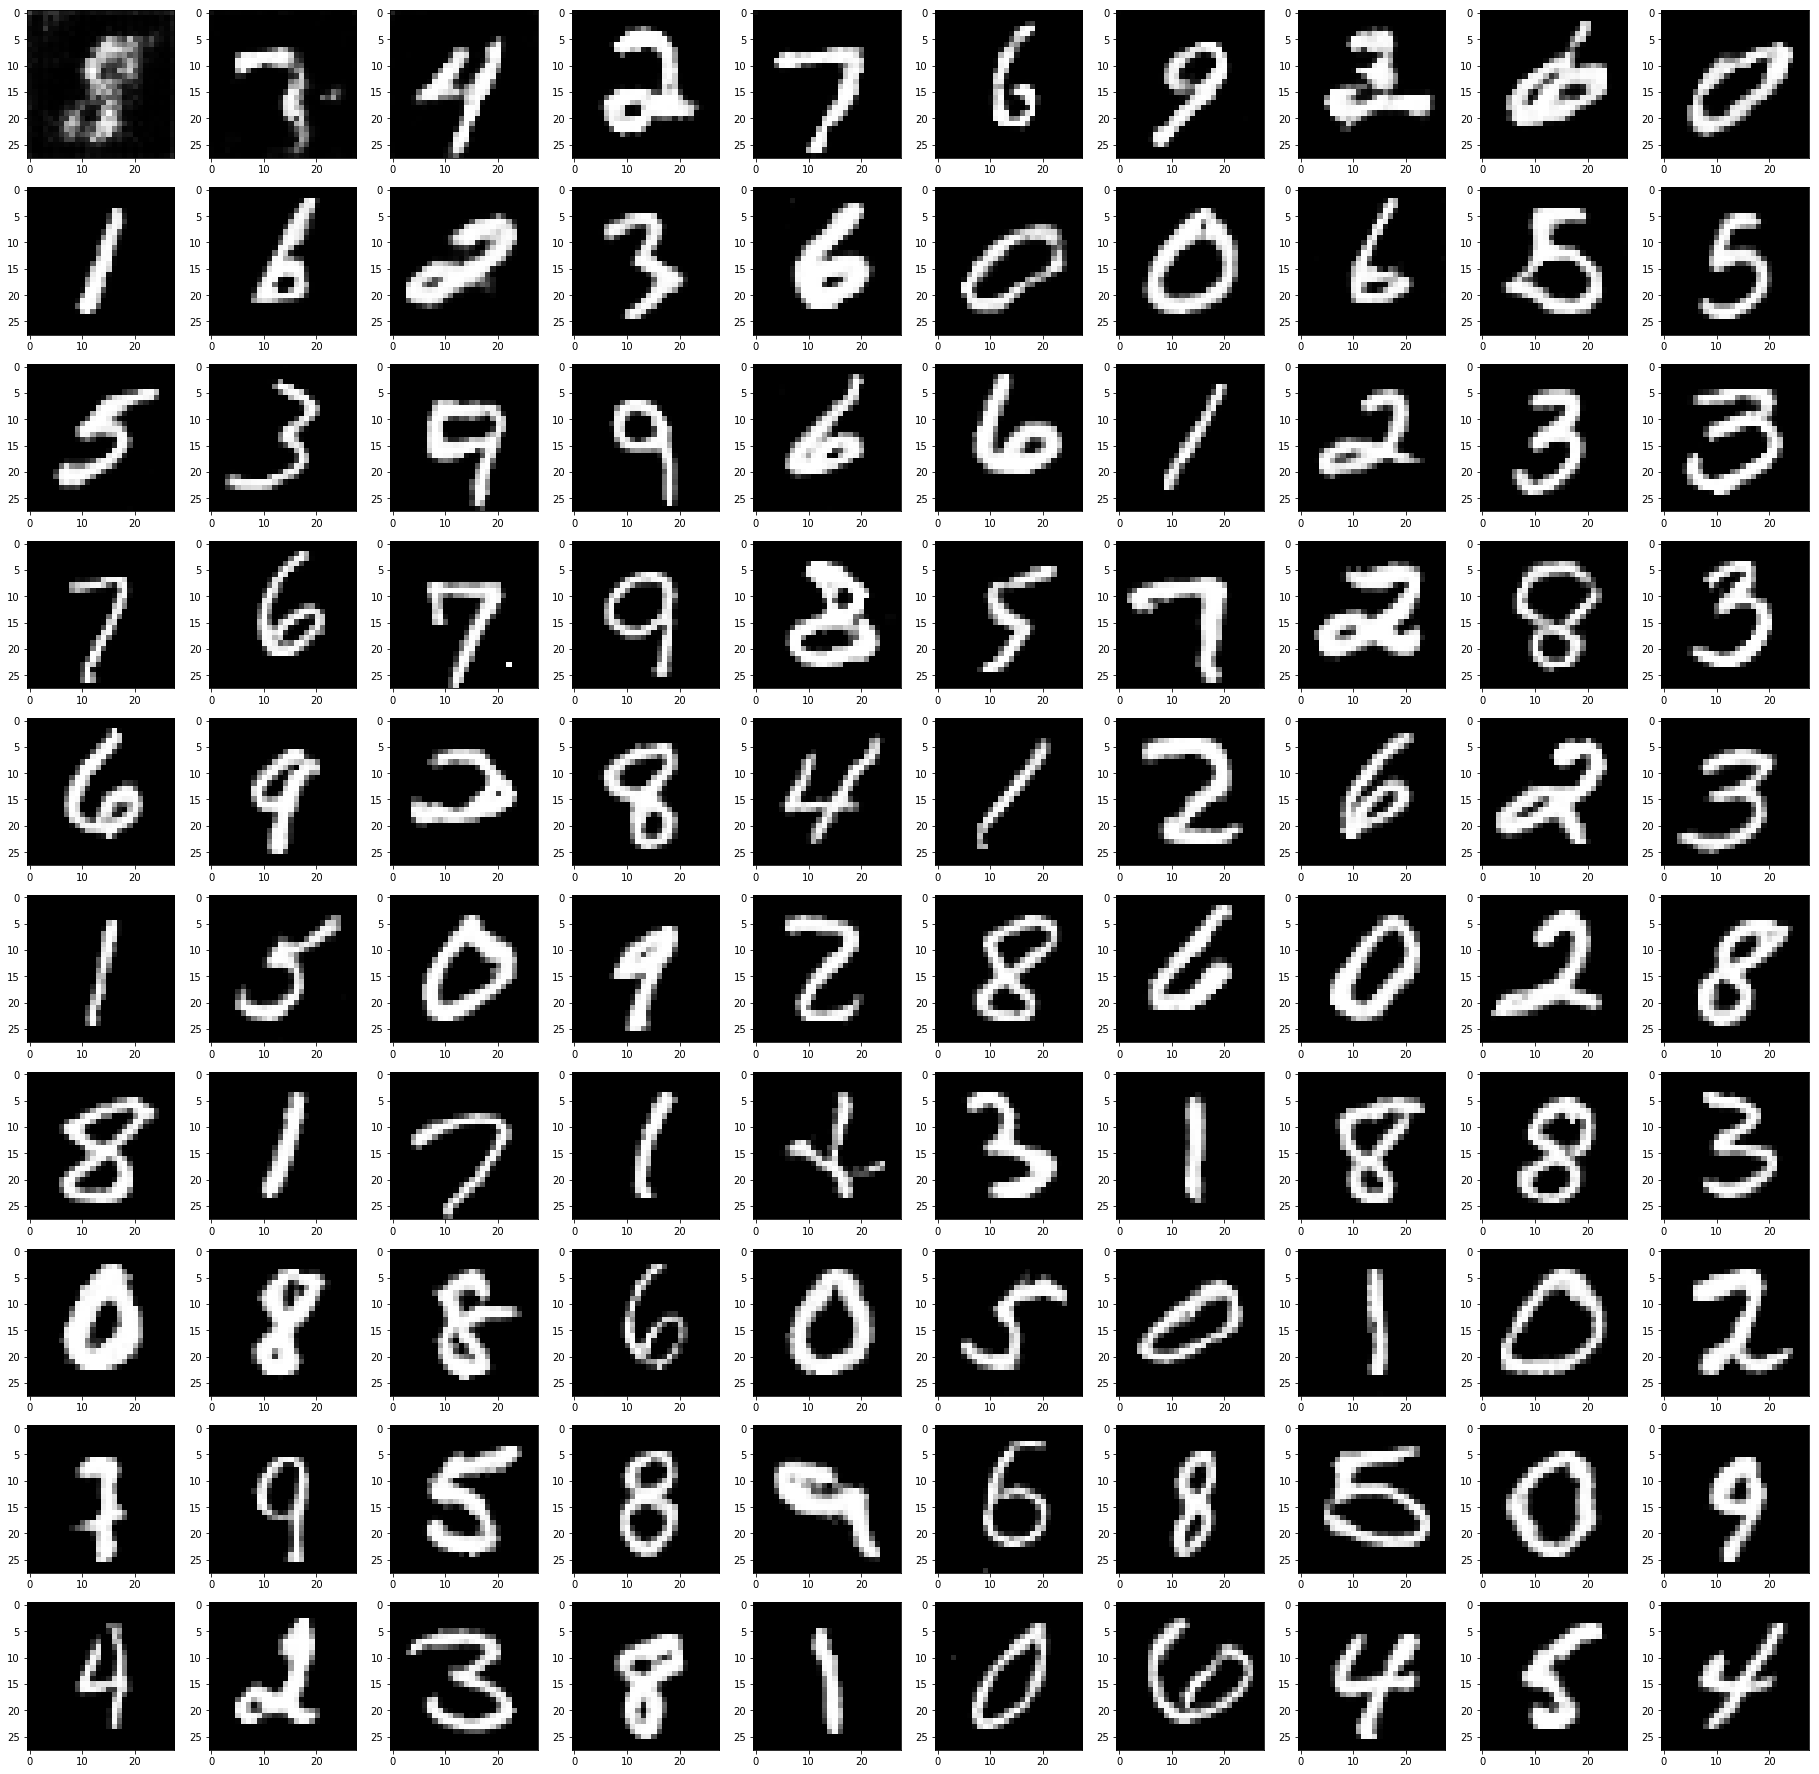

In [9]:
# Alright, everything's setup, let's run the GAN and train it
gan.train_all(train_loader)

In [10]:
gan.save('./mnist/')

In [11]:
gan.load('./mnist/')

## Display 10 digits from each multinomial coding vector possibility

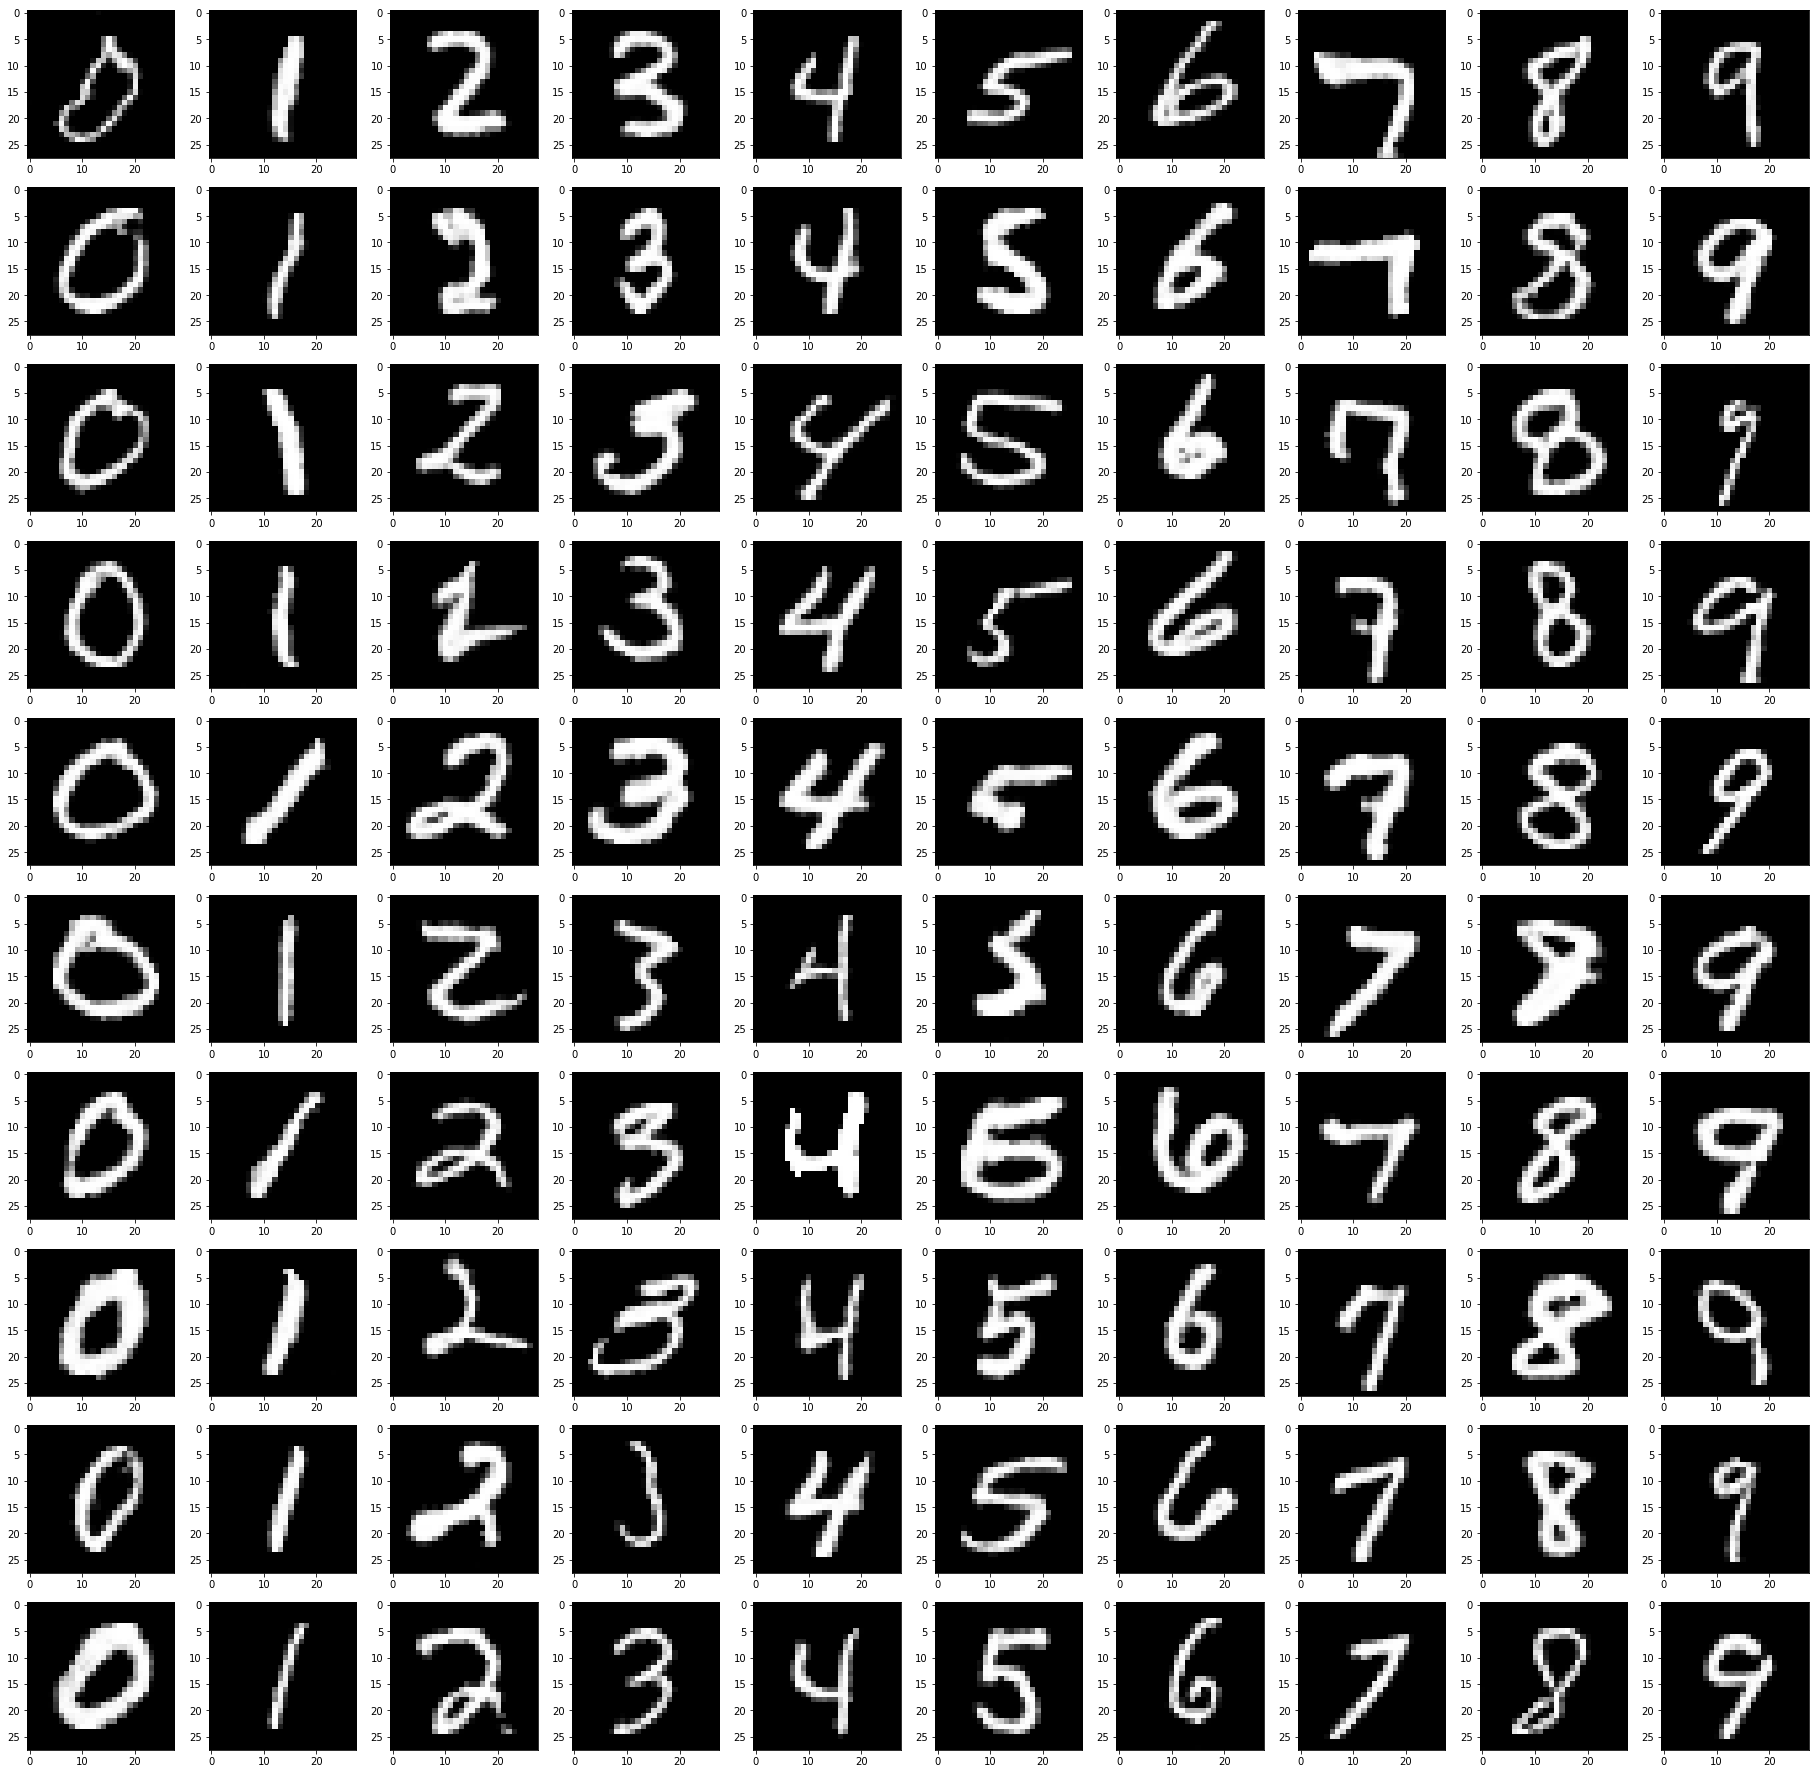

In [12]:
plt.figure(0, figsize = (32, 32))

z_dict = gan.get_z(c1_len * 10, sequential = True)
out_gen = gan.gen(torch.cat([z_dict[k] for k in z_dict.keys()], dim = 1))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j + 1
        plt.subplot(10, 10, idx)
        plt.imshow(np.round(out_gen[idx - 1, 0].cpu().data.numpy() * 255), cmap = 'gray')

## Run our InfoGAN on the test set and see how good are the results. Only works for semisupervised InfoGAN

In [13]:
out_test = gan.run_dis(Variable(x_test_th).cuda().float() / 255)[1]
out_test = np.argmax(out_test.data.cpu().numpy(), axis = 1)

In [14]:
print(np.mean(out_test == np.argmax(y_test, axis = 1)))

0.9669
